In [82]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

In [83]:
def sample(probabilities, mode = 'bernoulli'):
    if mode == 'bernoulli':
        return tf.floor(probabilities + tf.random_uniform(tf.shape(probabilities), 0, 1))
    elif mode == 'gaussian':
        return tf.add(probabilities, tf.random_normal(tf.shape(proababilities), mean = 0.0,  stddev= 1.0))
        

In [95]:
class RBM:
    def  __init__(self, n_visible, n_hidden, lr, epochs, mode = 'bernoulli'):
        ''' Initializing model with one layer of RBM'''
        self.mode = mode #bernoulli or gaussian
        self.n_hidden = n_hidden
        self.n_visible = n_visible
        self.lr = lr
        self.epochs = epochs
        
        #Initialize weights and biases
        with tf.name_scope('Weights'):
            self.W = tf.Variable( tf.random_normal(shape = [n_visible, n_hidden], mean= 0.0, stddev =  4*np.sqrt(6.0 / (self.n_visible +self.n_hidden))), name = 'weights')
        tf.summary.histogram('weights', self.W)
        self.vb = tf.Variable(tf.zeros(shape =[1, n_visible]), tf.float32, name= 'visible_bias')
        self.hb = tf.Variable(tf.zeros(shape = [1, n_hidden]), tf.float32, name = 'hidden_bias')
        
    def get_probabilities(self, layer, val):
        '''Return tensor of probs for a given layer'''
        if layer == 'hidden':
            with tf.name_scope("Hidden_Probabilities"):
                if self.mode == 'bernoulli':
                    return tf.nn.sigmoid(tf.matmul(val, self.W) +self.hb)
                elif self.mode == 'gaussian':
                    return tf.matmul(val, self.W)+ self.hb
                
        elif layer == 'visible':
            with tf.name_scope("Visible_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, tf.transpose(self.W))+ self.vb)
            
    def CD(self, v, K=1):
        '''K- step Contrastive Divergence using Gibbs sampling. Return parameters update.'''
        with tf.name_scope("Contrastive_Divergence"):
            h_prob = self.get_probabilities('hidden', v)
            # Positive Divergence + h(v).v^T
            #v is the actual real data sample
            # h(v) = sigmoid(W*v)
            pos_divergence = tf.matmul(tf.transpose(v), h_prob)
            
            #here h_state is the initial state ususally MCMCs get started with
            #since this is Contrastive Divergence, we start off with real data with some noise added to it
            h_state = sample(h_prob, mode= self.mode)
            dream_v_prob = self.get_probabilities('visible', h_state)
            dream_v_state = dream_v_prob
            
            dream_h_prob = self.get_probabilities('hidden', dream_v_state)
            dream_h_state = sample(dream_h_prob, mode= self.mode)
            #Just completed 1st MC sample
            
            #Now burn through K states or chains
            for i in range(K-1):
                
                dream_v_prob = self.get_probabilities('visible', dream_h_state)
                dream_v_state = dream_v_prob
                
                dream_h_prob = self.get_probabilities('hidden', dream_v_state)
                dream_h_state = sample(dream_h_prob, mode= self.mode)
                
            #now compute the negative/partion function part
            neg_divergence = tf.matmul(tf.transpose(dream_v_state), dream_h_prob)
            
            #normalizedLogProb
            dW = pos_divergence- neg_divergence
            dvb = v-dream_v_state
            dhb = h_prob-dream_h_prob
            
            #Reconstruction error at the visible layer
            self.rec_error = tf.reduce_mean(tf.squared_difference(v, dream_v_state))
            
            #change in parameters
            self.div = tf.reduce_mean(tf.abs(dW))
            
            return dW, dvb, dhb
        
    def update(self, v, K=1):
        batch_size = tf.cast(tf.shape(v)[0], tf.float32)
        dW, dvb, dhb= self.CD(v, K=K)
        
        delta_w = (self.lr/batch_size)*dW
        delta_vb = (self.lr/batch_size)*(tf.reduce_sum(dvb, 0, keep_dims= True))
        delta_hb = (self.lr/batch_size)*(tf.reduce_sum(dhb, 0, keep_dims= True))
        
        train_op = [self.W.assign_add(delta_w), self.vb.assign_add(delta_vb), self.hb.assign_add(delta_hb)]
        
        return train_op
    
    def gibbs(self, steps, v):
        '''Using gibbs sampling for hidden, visible nodes in the network'''
        with tf.name_scope("Gibbs_sampling"):
            for i in range(steps):
                hidden_p = self.get_probabilities('hidden', v)
                h = sample(hidden_p, mode=self.mode)
                
                
                visible_p = self.get_probabilities('visible', h)
                v = visible_p
        # we always want visible samples given a sample real data p
        return visible_p
    
    def free_energy(self, v):
        '''compute the free energy for a visible state'''
        vbias_term = tf.matmul(v, tf.transpose(self.vb))
        
        x_b = tf.matmul(v, self.W)+ self.hb
        hidden_term = tf.reduce_sum(tf.log(1+ x_b))
        
        return -hidden_term -vbias_term

    def feature_map(self):
        '''Return hidden features '''
        #activating each hidden node, and seeing their projections on the visible nodes
        ft_map = {}
        for k in range(self.n_hidden):
            ft_map[k] = self.get_probabilities('visible', tf.expand_dims(tf.one_hot(k+1, self.n_hidden),0))
        
        return ft_map     

# Initializing RBM

In [85]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [96]:
tf.reset_default_graph()

In [97]:
rbm_model = RBM(n_visible = 784, n_hidden= 144, lr = tf.constant(0.05, tf.float32), epochs = 1000, mode = 'bernoulli')
v = tf.placeholder(tf.float32, shape = [None, rbm_model.n_visible],  name = 'visible_layer')

# Update rule
k=10
train_op = rbm_model.update(v, K=k)

# Free energy
energy = rbm_model.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Save & restore all the variables.
saver = tf.train.Saver({"weights":rbm_model.W, "visible_bias":rbm_model.vb, "hidden_bias":rbm_model.hb})

# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [98]:
for epoch in tqdm(range(rbm_model.epochs)):
    if epoch % 100 == 0:
        result = sess.run([rbm_model.rec_error], feed_dict = {v: mnist.test.images})
        if epoch % 100 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
        #test_writer.add_summary(result[1],epoch)

    batchXs, batchYs = mnist.train.next_batch(32)
    sess.run(train_op, feed_dict = {v: batchXs})

save_path = saver.save(sess, os.getcwd()+"/saved_model/actor.ckpt")
print("Saving model at: %s"%(save_path))

  1%|          | 11/1000 [00:01<02:05,  7.85it/s]

Reconstruction error at step 0: 0.420


 12%|█▏        | 118/1000 [00:03<00:27, 32.60it/s]

Reconstruction error at step 100: 0.063


 22%|██▏       | 217/1000 [00:05<00:20, 38.96it/s]

Reconstruction error at step 200: 0.054


 31%|███▏      | 313/1000 [00:07<00:16, 41.27it/s]

Reconstruction error at step 300: 0.050


 42%|████▏     | 421/1000 [00:09<00:13, 43.69it/s]

Reconstruction error at step 400: 0.048


 52%|█████▏    | 521/1000 [00:11<00:10, 44.30it/s]

Reconstruction error at step 500: 0.046


 62%|██████▏   | 619/1000 [00:13<00:08, 45.13it/s]

Reconstruction error at step 600: 0.046


 71%|███████   | 709/1000 [00:15<00:06, 44.55it/s]

Reconstruction error at step 700: 0.045


 81%|████████▏ | 814/1000 [00:18<00:04, 43.95it/s]

Reconstruction error at step 800: 0.044


 92%|█████████▏| 917/1000 [00:20<00:01, 44.04it/s]

Reconstruction error at step 900: 0.043


100%|██████████| 1000/1000 [00:21<00:00, 46.20it/s]


Saving model at: /Users/phaniram/Downloads/Tensorflow-Bootcamp-master/03-Convolutional-Neural-Networks/Deep_RL/saved_model/actor.ckpt


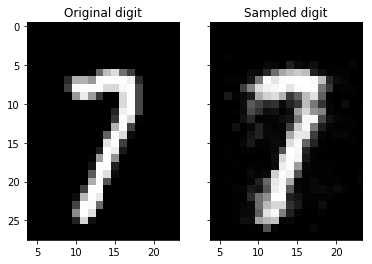

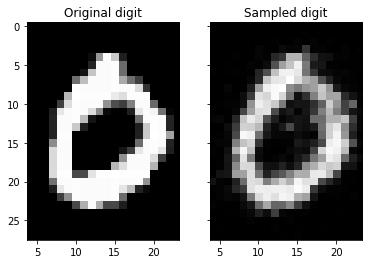

In [102]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original digit')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Sampled digit')
    plt.show()

train_image = mnist.train.images[5] # from train distribution
sample_train = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: train_image.reshape(1,-1).astype(np.float32)})  
show_digit(original=train_image, fake=sample_train)  

test_image = mnist.test.images[3] # from test distribution
sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
show_digit(original=test_image, fake=sample_test)  

tf.reset_default_graph()